# 1. Processamento de áreas claras

É realizado um processamento de áreas claras a fim de obter os prédios industriais que utilizam telhas de alumínio.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import morphology
import numpy as np
import cv2

from areas_claras_detector import AreasClarasDetector
from bing_maps import BingMaps

import utils

## 1.1 Imagem base

A imagem base de testes é a imagem do satélite obtida pelo Bing do IFCE - Campus Maracanaú.

Esta imagem é uma boa canditada aos testes por possuir áreas _residenciais_ e _industriais_.

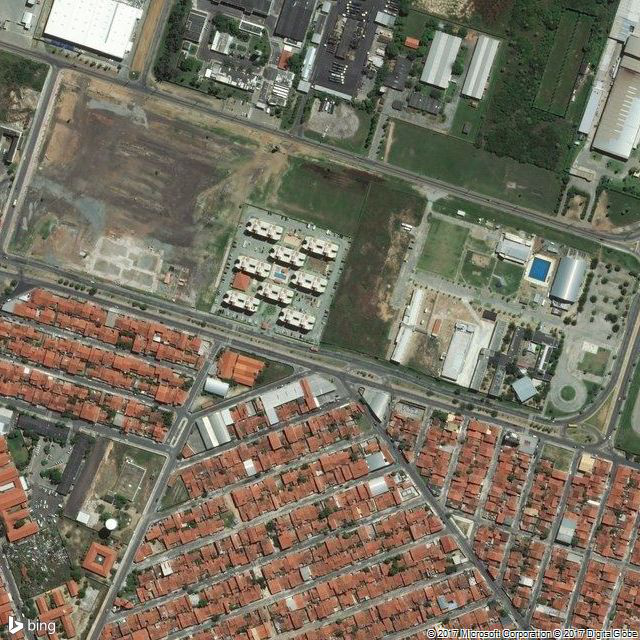

In [2]:
maps = BingMaps('AjhkGze8sCMwACt6rQMCS4ykL0gtBEyb6ku3Fqp78m9TsrrZ9qHHPAf_S8zjJFpR')

image = maps.image(-3.8722232, -38.6133724, 17, width=640, height=640)
image

## 1.2 `class AreasClarasDetector()`

Foi implementado a classe `AreasClarasDetector` que realiza os processamentos para obtenção das áreas claras da imagem

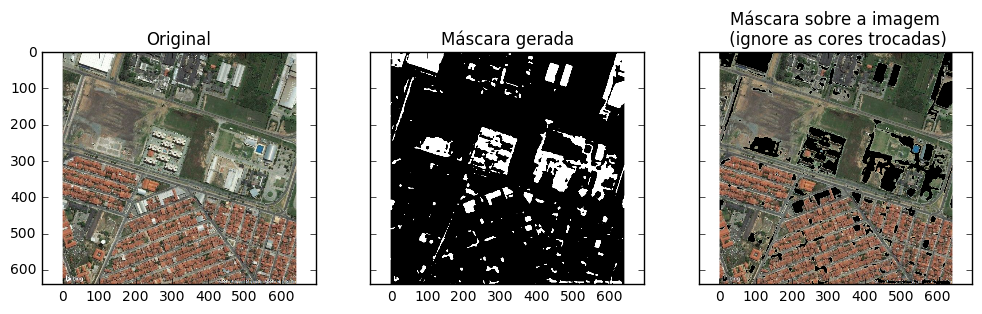

In [3]:
detector = AreasClarasDetector()

mascara = detector.processar_imagem(np.asarray(image))

grid = utils.ImagemGrid()
grid.show(
    (image, 'Original'),
    (mascara, 'Máscara gerada'),
    (utils.apply_mask(image, mascara), 'Máscara sobre a imagem\n (ignore as cores trocadas)'),
    cmap='gray'
)

### 1.2.1 Como funciona

São realizados os passos:

1. Saturação: destacar o que é mais preto e o que é mais branco. Foi utilizado [`adjust_sigmoid`](http://scikit-image.org/docs/dev/api/skimage.exposure.html#adjust-sigmoid);
> Performs Sigmoid Correction on the input image.
> Also known as Contrast Adjustment. This function transforms the input image pixelwise according to the equation `O = 1/(1 + exp*(gain*(cutoff - I)))` after scaling each pixel to the range 0 to 1.
2. Borramento: A saturação irá gerar pontinhos pequenos brancos. É feito um pequeno borramento ($sigma = 2$) para ignorá-los
3. Limiarização: É gerada uma máscara com os cuja intensidade seja $ > 150$.

É importante ainda causar alguma erosão (ou processo similar) no resultado de `areasClarasDetector.processar_imagem(imagem)`, de forma que sejam eliminados pequenas sujeiras, como as linhas brancas das calçadas ao lado das pistas. A classe **não faz isso**. Você deve fazer manualmente, assim como no exemplo abaixo.

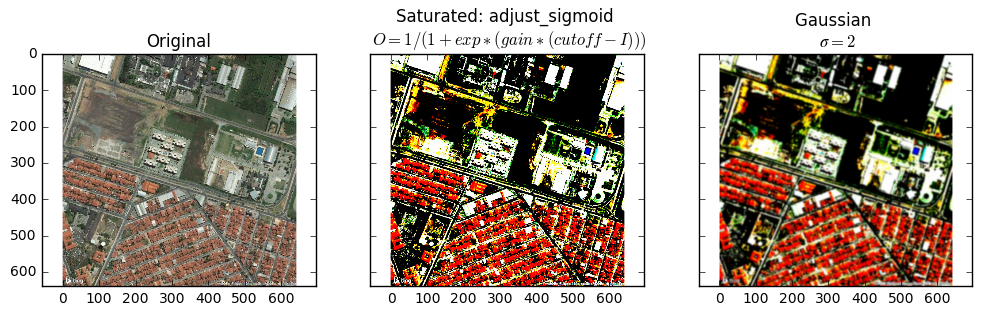

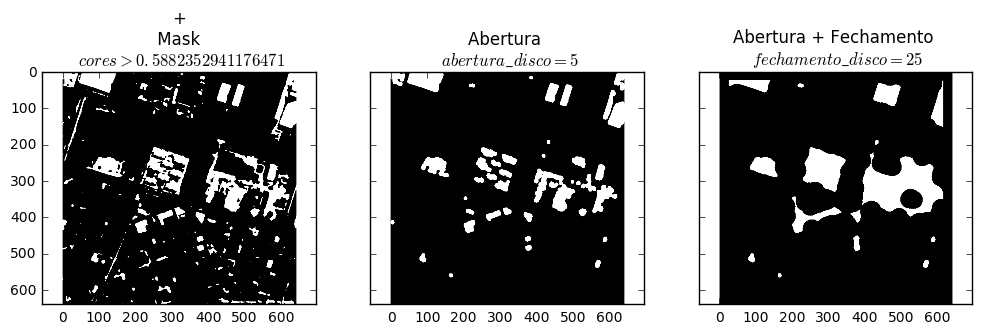

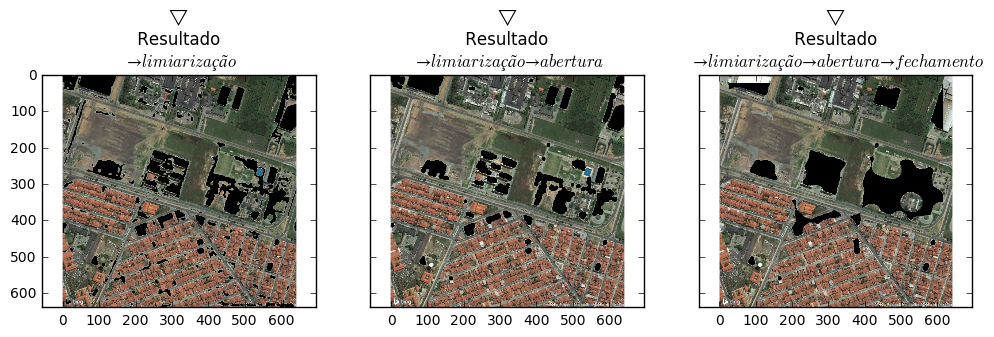

In [4]:
detector = AreasClarasDetector()

saturada = detector.saturar(np.asarray(image))
borrada = detector.borrar(saturada)

limiar_minimo = 150/255
limiar_maximo = 1.1
limiarizada = detector.limiarizar(borrada, limiar_minimo, limiar_maximo)

limiarizada_abertura = morphology.binary_opening(limiarizada, morphology.disk(5))
limiarizada_fechamento = morphology.binary_closing(limiarizada_abertura, morphology.disk(25))


grid = utils.ImagemGrid()
grid.show(
    (image, 'Original'),
    (saturada, 'Saturated: adjust_sigmoid \n $O = 1/(1 + exp*(gain*(cutoff - I)))$'),
    (borrada, 'Gaussian \n $σ = 2$')
)

grid.show(
    (limiarizada, '+\n Mask \n $cores > {} $'.format(limiar_minimo)),
    (limiarizada_abertura, 'Abertura \n $abertura\_disco = 5$'),
    (limiarizada_fechamento, 'Abertura + Fechamento \n $fechamento\_disco = 25$'),
    cmap='gray'
)

grid.show(
    (utils.apply_mask(image, limiarizada > 0), '$▽$ \n Resultado \n $→ limiarização$'),
    (utils.apply_mask(image, limiarizada_abertura), '$▽$ \n Resultado \n $→ limiarização → abertura$'),
    (utils.apply_mask(image, limiarizada_fechamento), '$▽$ \n Resultado \n $→ limiarização → abertura → fechamento$')
)

### 1.2.2 Resultado: Demarcação das áreas

A demarcação das áreas a seguir foi obtida a partir da máscara de **abertura** da seção anterior.

Observe que ele se comporta bem para obter áreas claras, porém se confunde com regiões com cor acinzentada clara, como pista de calçamento.

/home/paulo/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


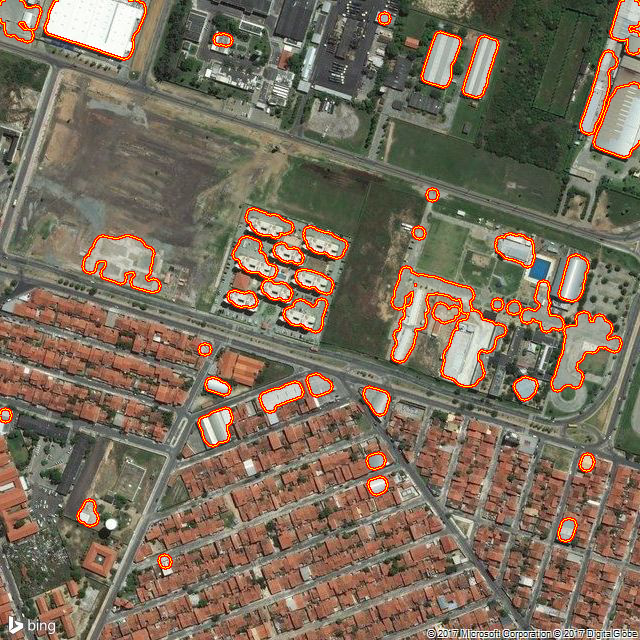

In [5]:
utils.skshow(utils.marcar_areas(np.asarray(image), limiarizada_abertura, outline_color=(1, 0, 0)))